<a href="https://colab.research.google.com/github/ignacioaranguren1/bd_2/blob/main/bd_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import keras_tuner
import datetime as dt

from tqdm import tqdm
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import BatchNormalization

In [2]:
%matplotlib inline

datapath = r'/Users/ignacioaranguren/bd_2/data'
os.chdir(datapath)

1.In the data used by Gu, Kelly and Xiu (RFS 2019 – provided in class), use a similar procedure to theirs to predict stock returns with neural networks. Start by finding a suitable baseline configuration, and use a validation procedure to pick optimal hyperparameters for three neural network models: One with 2 hidden layers, one with 3 hidden layers, and one with 4 hidden layers. 

In [3]:
data = pd.read_pickle('returns_chars_panel.pkl')
macro = pd.read_pickle('macro_timeseries.pkl')

In [4]:
def train_validation_test_split(data,train_end_date,validation_end_date):
  tmp = data.reset_index()
  train = tmp[tmp.date<=train_end_date].set_index(['date','permno'],drop=True)
  validation = tmp[(tmp.date>train_end_date) & (tmp.date<=validation_end_date)].set_index(['date','permno'],drop=True)
  test = tmp[tmp.date>validation_end_date].set_index(['date','permno'],drop=True)
  return train,validation,test

In [5]:
data_merged = pd.merge(data,macro,on=['date'])
datelist = list(set(data_merged['date']))
datelist.sort()
data_merged.set_index(['date','permno'],drop=True,inplace=True)

In [6]:
# It is worth mentioning that even though we have set these ratios in order to split the data set the resulting
# weighs are not exactly the same because dates can have more than one observation
train_ratio = 0.5
validation_ratio = 0.25
train_date = datelist[int(len(datelist)*train_ratio)]
validation_date = datelist[int(len(datelist)*(train_ratio+validation_ratio))]
X = data_merged.iloc[:,3:].copy()
y = data_merged['excess_ret'].copy()

In [7]:
X_train,X_validation,X_test = train_validation_test_split(X,train_date,validation_date)
y_train,y_validation,y_test = train_validation_test_split(y,train_date,validation_date)

In [24]:
def keras_model(n_layers, units, learning_rate):
    # Model definition separated from tuner in order to achieve modularity 
    # Build model
    model = Sequential()
    model.add(layers.Input(shape=(105,)))
    # Add layers iteratively and assign a units hyperparam selector
    for i in range(n_layers):
        model.add(BatchNormalization()) # Normalizing before activation seems to yield better results than after
        model.add(layers.Dense(units=units[0][i], activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse')
    return model

class HyperRegressor(keras_tuner.HyperModel):
    def __init__(self, n_layers, *args, **kwargs):
        # Pass all arguments except number of layers to parent
        self.n_layers = n_layers
        super().__init__(*args, **kwargs)

    def build(self, hp):
        # Hyperparameters choices and ranges definition 
        # To increase modularity, we declare units choice for each layer in a list 
        units=[hp.Int(f'units_{i + 1}',min_value=16,max_value=160,step=16) for i in range(self.n_layers)],
        learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
        return keras_model(self.n_layers, units, learning_rate)

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        model.fit(x, y, **kwargs)
        x_val, y_val = validation_data
        y_pred = model.predict(x_val)
        # Return a single float to minimize.
        return np.mean((y_pred - y_val)**2)

In [25]:
########################
# CONSTANTS DEFINITION #
########################

MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 3
EPOCHS = 8
BATCH_SIZE = 256

def tune_model(n_layers=2):
  # Early stop if loss does not improve after 3 epochs
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  tuner = RandomSearch(
        hypermodel=HyperRegressor(n_layers),
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        overwrite=True,
        directory='bd_2',
        project_name=f'NN_new_{n_layers}'
  )
  tuner.search(
      X_train.values, 
      y_train.values,
      validation_data=(X_validation.values, y_validation.values),
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[callback]
  )
  return tuner

In [12]:
models = []
parameters = []
tuners = []
for n in range(2,5):
    tuner = tune_model(n)
    parameters.append(tuner.get_best_hyperparameters)
    models.append(tuner.get_best_models(1)[0])
    tuners.append(tuner)

Trial 10 Complete [00h 09m 28s]
default_objective: 0.04740524855275794

Best default_objective So Far: 0.04082417058268804
Total elapsed time: 01h 34m 14s
INFO:tensorflow:Oracle triggered exit


In [26]:
for i in range(3):
  print(tuners[i].get_best_hyperparameters()[0].values)

{'units_1': 144, 'units_2': 64, 'learning_rate': 0.000256153969803113}
{'units_1': 64, 'units_2': 96, 'units_3': 112, 'learning_rate': 0.0013688978213179357}
{'units_1': 16, 'units_2': 48, 'units_3': 128, 'units_4': 144, 'learning_rate': 0.0005677736913894471}


In [13]:
with open('models.pkl','wb') as f:
  pickle.dump(models,f)
with open('tuners.pkl','wb') as f:
  pickle.dump(tuners,f)

INFO:tensorflow:Assets written to: ram://4cefee27-841d-4536-af97-baa27475d903/assets
INFO:tensorflow:Assets written to: ram://96fedd41-dad1-4d05-aea2-d2ce631fd171/assets
INFO:tensorflow:Assets written to: ram://b75f643e-f30a-4748-996b-531cb7f81058/assets


In [17]:
def format_units(buffer_dict):
      # Convert units param to a list of units to match processing formatting
      units = []
      # Check if key is unit, if it is add to list 
      for key, value  in buffer_dict.values.items():
          if 'units' in key:
              units += [value]
      # Crate new dict with correct format 
      best_params = {}
      best_params['units'] = [units]
      best_params['learning_rate'] = buffer_dict['learning_rate']
      return best_params

models_refitted = []
results = {}
for i in range(3):
    # Build and refit model with best params
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    best_hps = format_units(tuners[i].get_best_hyperparameters()[0])
    n_layers = len(best_hps['units']) # Get num of hidden layers
    model = keras_model(n_layers, **best_hps) # Rebuild model
    model.fit(X, y, epochs=64, batch_size=256,verbose=True, callbacks=[callback])
    models_refitted.append(model)
    # Evaluate train, val and test 
    train_result = model.evaluate(X_train.values,y_train.values,batch_size=256)
    test_result = model.evaluate(X_test.values,y_test.values,batch_size=256)
    val_result = model.evaluate(X_validation.values,y_validation.values,batch_size=256)
    results[f'NN{i + 1}'] = {'train': train_result, 'validation': val_result, 'test': test_result}

Epoch 1/64
14608/14608 [==============================] - 35s 2ms/step - loss: 0.0554
Epoch 2/64
14608/14608 [==============================] - 32s 2ms/step - loss: 0.0296
Epoch 3/64
14608/14608 [==============================] - 32s 2ms/step - loss: 0.0293
Epoch 4/64
14608/14608 [==============================] - 32s 2ms/step - loss: 0.0291
Epoch 5/64
14608/14608 [==============================] - 32s 2ms/step - loss: 0.0289
Epoch 6/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0288
Epoch 7/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0287
Epoch 8/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0286
Epoch 9/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0285
Epoch 10/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0284
Epoch 11/64
14608/14608 [==============================] - 31s 2ms/step - loss: 0.0283
Epoch 12/64
14608/14608 [===========================

In [18]:
results

{'NN1': {'test': 0.024710332974791527,
  'train': 0.02167060784995556,
  'validation': 0.03952166065573692},
 'NN2': {'test': 0.023484626784920692,
  'train': 0.021047215908765793,
  'validation': 0.037058476358652115},
 'NN3': {'test': 0.023973975330591202,
  'train': 0.021303806453943253,
  'validation': 0.03852330520749092}}

In [18]:
with open('refitted_models_BN.pkl','wb') as f:
  pickle.dump(models_refitted,f)

INFO:tensorflow:Assets written to: ram://badb6e86-648e-47cd-a306-01eaf114f5b5/assets
INFO:tensorflow:Assets written to: ram://b003ddc8-fec3-4294-8f3f-28fbafbf577b/assets
INFO:tensorflow:Assets written to: ram://21149ecd-ca54-4391-b42a-2d8bc73ff3c4/assets


2.Use test data to get an idea of the out of sample performance of each model. Convert the standard MSE metric for out of sample performance to the “R2 out of sample” metric that was discussed in class. Compare your results to those in Gu-Kelly-Xiu and comment on the differences. 

In [26]:
with open('models.pkl','rb') as f:
  models = pickle.load(f)
with open('tuners.pkl','rb') as f:
  tuners = pickle.load(f)
with open('refitted_models_BN.pkl','rb') as f:
  models_refitted = pickle.load(f)

In [27]:
def r_squared(y_pred, y_test):
    return 1 - np.sum((y_test - y_pred)**2) / np.sum(y_test**2)

In [28]:
rankings = X_test['mvel1'].groupby(['date']).rank()
top_X_test = X_test.loc[rankings<=1000,:].values
top_y_test = y_test.loc[rankings<=1000,:].values
rankings_reverse = X_test['mvel1'].groupby(['date']).rank(ascending=False)
bottom_X_test = X_test.loc[rankings_reverse<=1000,:].values
bottom_y_test = y_test.loc[rankings_reverse<=1000,:].values

In [30]:
R2_oos_df = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['NN2','NN3','NN4'])
for i in range(3):
    y_pred_all = models_refitted[i].predict(X_test,batch_size=256).reshape(-1,1)
    y_pred_top = models_refitted[i].predict(top_X_test,batch_size=256).reshape(-1,1)
    y_pred_bottom = models_refitted[i].predict(bottom_X_test,batch_size=256).reshape(-1,1)
    
    row = [r_squared(y_pred_all, y_test)[0],
           r_squared(y_pred_top, top_y_test),
           r_squared(y_pred_bottom, bottom_y_test)]
    
    R2_oos_df.iloc[i]= row

700/700 [==============================] - 0s 641us/step


In [31]:
R2_oos_df * 100

,R2_OOS,R2_OOS_top1000,R2_OOS_low1000
NN2,11.614579,7.251403,21.135385
NN3,5.597416,4.051352,8.421495
NN4,15.510674,10.886926,26.439365


In [17]:
with open('r_squared.pkl','wb') as f:
  pickle.dump(R2_oos_df,f)

3.Pick the model that performs the best out of sample, and interpret its output by doing the following analysis of variable importance:
a.	First, for all stock characteristics, get variable importance by setting one predictor at a time to zero and finding the decrease in out of sample R2. Show a table of the 10 most important variables according to this measure, and give an economic interpretation. 


In [32]:
with open('refitted_models_BN.pkl','rb') as f:
  models_refitted = pickle.load(f)
with open('r_squared.pkl','rb') as f:
  R2_oos_df = pickle.load(f)

In [33]:
# from IPython.display import display
sub = R2_oos_df[R2_oos_df['R2_OOS'] == R2_oos_df['R2_OOS'].max()].index[0]
ind = R2_oos_df.index.tolist().index(sub)
best_model = models_refitted[ind]

In [34]:
best_r_squared = max(R2_oos_df.iloc[:,0])
best_r_squared * 100

15.510674225049337

In [15]:
feature_importance = {}
for column_name in tqdm(X_train.columns):
    X_tmp = X_test.copy()
    X_tmp[column_name] = 0
    y_pred_temp = best_model.predict(X_tmp, batch_size=256).reshape(-1,1)
    feature_importance[column_name] = best_r_squared - r_squared(y_pred_temp, y_test)[0]


  0%|                                                   | 0/105 [00:00<?, ?it/s]

4312/4312 [==============================] - 3s 666us/step


  1%|▍                                          | 1/105 [00:06<10:28,  6.05s/it]

4312/4312 [==============================] - 3s 680us/step


  2%|▊                                          | 2/105 [00:12<10:45,  6.27s/it]

4312/4312 [==============================] - 3s 685us/step


  3%|█▏                                         | 3/105 [00:21<12:36,  7.42s/it]

4312/4312 [==============================] - 4s 825us/step


  4%|█▋                                         | 4/105 [00:28<12:24,  7.37s/it]

4312/4312 [==============================] - 3s 701us/step


  5%|██                                         | 5/105 [00:35<12:00,  7.21s/it]

4312/4312 [==============================] - 3s 673us/step


  6%|██▍                                        | 6/105 [00:41<11:24,  6.92s/it]

4312/4312 [==============================] - 3s 664us/step


  7%|██▊                                        | 7/105 [00:48<11:23,  6.97s/it]

4312/4312 [==============================] - 3s 668us/step


  8%|███▎                                       | 8/105 [00:56<11:26,  7.08s/it]

4312/4312 [==============================] - 3s 656us/step


  9%|███▋                                       | 9/105 [01:02<10:41,  6.68s/it]

4312/4312 [==============================] - 3s 667us/step


 10%|████                                      | 10/105 [01:07<10:10,  6.42s/it]

4312/4312 [==============================] - 3s 654us/step


 10%|████▍                                     | 11/105 [01:13<09:47,  6.25s/it]

4312/4312 [==============================] - 3s 657us/step


 11%|████▊                                     | 12/105 [01:19<09:32,  6.15s/it]

4312/4312 [==============================] - 3s 671us/step


 12%|█████▏                                    | 13/105 [01:25<09:28,  6.18s/it]

4312/4312 [==============================] - 3s 649us/step


 13%|█████▌                                    | 14/105 [01:32<09:27,  6.23s/it]

4312/4312 [==============================] - 3s 768us/step


 14%|██████                                    | 15/105 [01:39<09:36,  6.41s/it]

4312/4312 [==============================] - 3s 669us/step


 15%|██████▍                                   | 16/105 [01:46<09:44,  6.57s/it]

4312/4312 [==============================] - 3s 663us/step


 16%|██████▊                                   | 17/105 [01:52<09:34,  6.52s/it]

4312/4312 [==============================] - 3s 660us/step


 17%|███████▏                                  | 18/105 [02:00<10:09,  7.01s/it]

4312/4312 [==============================] - 3s 665us/step


 18%|███████▌                                  | 19/105 [02:07<09:51,  6.88s/it]

4312/4312 [==============================] - 3s 664us/step


 19%|████████                                  | 20/105 [02:13<09:31,  6.72s/it]

4312/4312 [==============================] - 3s 797us/step


 20%|████████▍                                 | 21/105 [02:22<10:32,  7.53s/it]

4312/4312 [==============================] - 3s 755us/step


 21%|████████▊                                 | 22/105 [02:30<10:13,  7.40s/it]

4312/4312 [==============================] - 3s 799us/step


 22%|█████████▏                                | 23/105 [02:38<10:35,  7.75s/it]

4312/4312 [==============================] - 3s 698us/step


 23%|█████████▌                                | 24/105 [02:45<09:56,  7.36s/it]

4312/4312 [==============================] - 3s 703us/step


 24%|██████████                                | 25/105 [02:52<09:52,  7.41s/it]

4312/4312 [==============================] - 3s 646us/step


 25%|██████████▍                               | 26/105 [02:58<09:12,  6.99s/it]

4312/4312 [==============================] - 4s 917us/step


 26%|██████████▊                               | 27/105 [03:05<09:10,  7.05s/it]

4312/4312 [==============================] - 3s 775us/step


 27%|███████████▏                              | 28/105 [03:12<08:53,  6.93s/it]

4312/4312 [==============================] - 3s 729us/step


 28%|███████████▌                              | 29/105 [03:19<08:40,  6.85s/it]

4312/4312 [==============================] - 4s 973us/step


 29%|████████████                              | 30/105 [03:26<08:53,  7.12s/it]

4312/4312 [==============================] - 3s 712us/step


 30%|████████████▍                             | 31/105 [03:34<08:50,  7.18s/it]

4312/4312 [==============================] - 3s 656us/step


 30%|████████████▊                             | 32/105 [03:40<08:30,  6.99s/it]

4312/4312 [==============================] - 4s 854us/step


 31%|█████████████▏                            | 33/105 [03:50<09:23,  7.83s/it]

4312/4312 [==============================] - 3s 767us/step


 32%|█████████████▌                            | 34/105 [03:57<09:02,  7.63s/it]

4312/4312 [==============================] - 3s 670us/step


 33%|██████████████                            | 35/105 [04:03<08:26,  7.24s/it]

4312/4312 [==============================] - 3s 667us/step


 34%|██████████████▍                           | 36/105 [04:10<08:06,  7.05s/it]

4312/4312 [==============================] - 3s 660us/step


 35%|██████████████▊                           | 37/105 [04:16<07:46,  6.85s/it]

4312/4312 [==============================] - 3s 664us/step


 36%|███████████████▏                          | 38/105 [04:23<07:28,  6.70s/it]

4312/4312 [==============================] - 3s 666us/step


 37%|███████████████▌                          | 39/105 [04:29<07:20,  6.67s/it]

4312/4312 [==============================] - 3s 657us/step


 38%|████████████████                          | 40/105 [04:36<07:06,  6.56s/it]

4312/4312 [==============================] - 4s 934us/step


 39%|████████████████▍                         | 41/105 [04:43<07:18,  6.85s/it]

4312/4312 [==============================] - 3s 649us/step


 40%|████████████████▊                         | 42/105 [04:49<06:51,  6.53s/it]

4312/4312 [==============================] - 3s 659us/step


 41%|█████████████████▏                        | 43/105 [04:55<06:31,  6.31s/it]

4312/4312 [==============================] - 3s 651us/step


 42%|█████████████████▌                        | 44/105 [05:01<06:14,  6.14s/it]

4312/4312 [==============================] - 3s 650us/step


 43%|██████████████████                        | 45/105 [05:06<06:02,  6.03s/it]

4312/4312 [==============================] - 3s 670us/step


 44%|██████████████████▍                       | 46/105 [05:12<05:52,  5.98s/it]

4312/4312 [==============================] - 3s 653us/step


 45%|██████████████████▊                       | 47/105 [05:18<05:44,  5.95s/it]

4312/4312 [==============================] - 3s 721us/step


 46%|███████████████████▏                      | 48/105 [05:24<05:43,  6.03s/it]

4312/4312 [==============================] - 3s 765us/step


 47%|███████████████████▌                      | 49/105 [05:33<06:15,  6.70s/it]

4312/4312 [==============================] - 3s 678us/step


 48%|████████████████████                      | 50/105 [05:39<06:06,  6.66s/it]

4312/4312 [==============================] - 3s 660us/step


 49%|████████████████████▍                     | 51/105 [05:45<05:52,  6.53s/it]

4312/4312 [==============================] - 3s 658us/step


 50%|████████████████████▊                     | 52/105 [05:52<05:41,  6.45s/it]

4312/4312 [==============================] - 7s 2ms/step


 50%|█████████████████████▏                    | 53/105 [06:05<07:30,  8.67s/it]

4312/4312 [==============================] - 3s 669us/step


 51%|█████████████████████▌                    | 54/105 [06:12<06:49,  8.03s/it]

4312/4312 [==============================] - 3s 660us/step


 52%|██████████████████████                    | 55/105 [06:18<06:11,  7.42s/it]

4312/4312 [==============================] - 3s 660us/step


 53%|██████████████████████▍                   | 56/105 [06:24<05:46,  7.07s/it]

4312/4312 [==============================] - 3s 670us/step


 54%|██████████████████████▊                   | 57/105 [06:31<05:38,  7.05s/it]

4312/4312 [==============================] - 3s 658us/step


 55%|███████████████████████▏                  | 58/105 [06:37<05:19,  6.79s/it]

4312/4312 [==============================] - 3s 659us/step


 56%|███████████████████████▌                  | 59/105 [06:45<05:19,  6.94s/it]

4312/4312 [==============================] - 3s 684us/step


 57%|████████████████████████                  | 60/105 [06:51<04:59,  6.65s/it]

4312/4312 [==============================] - 3s 704us/step


 58%|████████████████████████▍                 | 61/105 [06:57<04:44,  6.46s/it]

4312/4312 [==============================] - 3s 656us/step


 59%|████████████████████████▊                 | 62/105 [07:03<04:29,  6.28s/it]

4312/4312 [==============================] - 3s 652us/step


 60%|█████████████████████████▏                | 63/105 [07:08<04:18,  6.15s/it]

4312/4312 [==============================] - 3s 652us/step


 61%|█████████████████████████▌                | 64/105 [07:14<04:08,  6.07s/it]

4312/4312 [==============================] - 3s 665us/step


 62%|██████████████████████████                | 65/105 [07:20<04:00,  6.02s/it]

4312/4312 [==============================] - 3s 664us/step


 63%|██████████████████████████▍               | 66/105 [07:26<03:53,  6.00s/it]

4312/4312 [==============================] - 3s 669us/step


 64%|██████████████████████████▊               | 67/105 [07:34<04:04,  6.42s/it]

4312/4312 [==============================] - 3s 659us/step


 65%|███████████████████████████▏              | 68/105 [07:40<03:57,  6.41s/it]

4312/4312 [==============================] - 3s 658us/step


 66%|███████████████████████████▌              | 69/105 [07:46<03:47,  6.32s/it]

4312/4312 [==============================] - 3s 667us/step


 67%|████████████████████████████              | 70/105 [07:52<03:39,  6.27s/it]

4312/4312 [==============================] - 3s 695us/step


 68%|████████████████████████████▍             | 71/105 [08:00<03:50,  6.79s/it]

4312/4312 [==============================] - 3s 671us/step


 69%|████████████████████████████▊             | 72/105 [08:07<03:39,  6.64s/it]

4312/4312 [==============================] - 3s 696us/step


 70%|█████████████████████████████▏            | 73/105 [08:14<03:43,  6.99s/it]

4312/4312 [==============================] - 3s 667us/step


 70%|█████████████████████████████▌            | 74/105 [08:23<03:48,  7.38s/it]

4312/4312 [==============================] - 3s 659us/step


 71%|██████████████████████████████            | 75/105 [08:31<03:53,  7.79s/it]

4312/4312 [==============================] - 3s 656us/step


 72%|██████████████████████████████▍           | 76/105 [08:37<03:28,  7.21s/it]

4312/4312 [==============================] - 3s 659us/step


 73%|██████████████████████████████▊           | 77/105 [08:43<03:10,  6.79s/it]

4312/4312 [==============================] - 3s 652us/step


 74%|███████████████████████████████▏          | 78/105 [08:49<02:55,  6.48s/it]

4312/4312 [==============================] - 3s 658us/step


 75%|███████████████████████████████▌          | 79/105 [08:55<02:43,  6.29s/it]

4312/4312 [==============================] - 3s 654us/step


 76%|████████████████████████████████          | 80/105 [09:00<02:33,  6.13s/it]

4312/4312 [==============================] - 3s 655us/step


 77%|████████████████████████████████▍         | 81/105 [09:06<02:25,  6.04s/it]

4312/4312 [==============================] - 3s 682us/step


 78%|████████████████████████████████▊         | 82/105 [09:12<02:18,  6.01s/it]

4312/4312 [==============================] - 3s 671us/step


 79%|█████████████████████████████████▏        | 83/105 [09:18<02:14,  6.10s/it]

4312/4312 [==============================] - 3s 665us/step


 80%|█████████████████████████████████▌        | 84/105 [09:25<02:09,  6.18s/it]

4312/4312 [==============================] - 3s 658us/step


 81%|██████████████████████████████████        | 85/105 [09:31<02:04,  6.23s/it]

4312/4312 [==============================] - 3s 660us/step


 82%|██████████████████████████████████▍       | 86/105 [09:37<01:58,  6.25s/it]

4312/4312 [==============================] - 3s 672us/step


 83%|██████████████████████████████████▊       | 87/105 [09:44<01:56,  6.45s/it]

4312/4312 [==============================] - 3s 662us/step


 84%|███████████████████████████████████▏      | 88/105 [09:51<01:52,  6.59s/it]

4312/4312 [==============================] - 3s 657us/step


 85%|███████████████████████████████████▌      | 89/105 [09:58<01:44,  6.53s/it]

4312/4312 [==============================] - 3s 660us/step


 86%|████████████████████████████████████      | 90/105 [10:04<01:38,  6.55s/it]

4312/4312 [==============================] - 3s 661us/step


 87%|████████████████████████████████████▍     | 91/105 [10:11<01:31,  6.53s/it]

4312/4312 [==============================] - 3s 660us/step


 88%|████████████████████████████████████▊     | 92/105 [10:17<01:23,  6.43s/it]

4312/4312 [==============================] - 4s 927us/step


 89%|█████████████████████████████████████▏    | 93/105 [10:25<01:21,  6.78s/it]

4312/4312 [==============================] - 3s 675us/step


 90%|█████████████████████████████████████▌    | 94/105 [10:30<01:11,  6.52s/it]

4312/4312 [==============================] - 3s 666us/step


 90%|██████████████████████████████████████    | 95/105 [10:36<01:03,  6.33s/it]

4312/4312 [==============================] - 3s 665us/step


 91%|██████████████████████████████████████▍   | 96/105 [10:42<00:55,  6.19s/it]

4312/4312 [==============================] - 3s 656us/step


 92%|██████████████████████████████████████▊   | 97/105 [10:48<00:48,  6.07s/it]

4312/4312 [==============================] - 3s 660us/step


 93%|███████████████████████████████████████▏  | 98/105 [10:54<00:42,  6.01s/it]

4312/4312 [==============================] - 3s 654us/step


 94%|███████████████████████████████████████▌  | 99/105 [11:00<00:35,  5.96s/it]

4312/4312 [==============================] - 3s 667us/step


 95%|███████████████████████████████████████  | 100/105 [11:06<00:29,  5.96s/it]

4312/4312 [==============================] - 3s 665us/step


 96%|███████████████████████████████████████▍ | 101/105 [11:12<00:24,  6.06s/it]

4312/4312 [==============================] - 3s 657us/step


 97%|███████████████████████████████████████▊ | 102/105 [11:18<00:18,  6.14s/it]

4312/4312 [==============================] - 3s 654us/step


 98%|████████████████████████████████████████▏| 103/105 [11:25<00:12,  6.18s/it]

4312/4312 [==============================] - 3s 657us/step


 99%|████████████████████████████████████████▌| 104/105 [11:31<00:06,  6.18s/it]

4312/4312 [==============================] - 3s 660us/step


100%|█████████████████████████████████████████| 105/105 [11:37<00:00,  6.65s/it]


In [16]:
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['magnitude'])
# Retrieve 10 most significant
df_10 = importance_df.sort_values('magnitude').iloc[(len(importance_df['magnitude']) - 10):,]
# Display most significant features
df_10.index.values

array(['dfr', 'ntis', 'crsp_spvw', 'svar', 'tbl', 'b/m', 'tms', 'dfy',
       'ep_y', 'dp'], dtype=object)

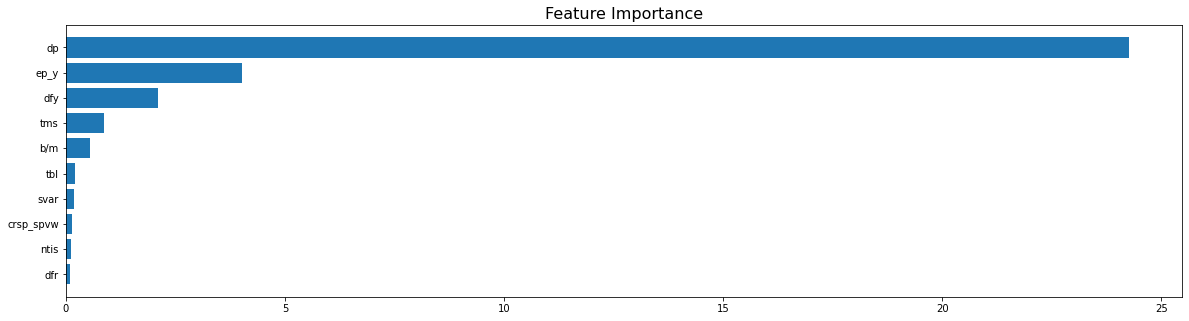

In [17]:
# Display chart
plt.figure(figsize=(20,5))
plt.barh(np.arange(len(df_10)),df_10.magnitude.values)
plt.yticks(np.arange(len(df_10)),df_10.index.values)
plt.title('Feature Importance',size=16)
plt.show()

b.	Second, get a measure of the joint importance of all our “macro predictors” (i.e., those taken from Welch and Goyal 2008), by setting them all to zero and finding the decrease in out of sample R2. Comment on how important macroeconomic variables are relative to stock characteristics in predicting returns. 

In [73]:
feature_importance = {}
for column_name in tqdm(X_train.columns[-11:]):
    X_tmp = X_test.copy()
    X_tmp[column_name] = 0
    y_pred_temp = best_model.predict(X_tmp, batch_size=256).reshape(-1,1)
    feature_importance[column_name] = best_r_squared - r_squared(y_pred_temp, y_test)[0]

  0%|                                                    | 0/11 [00:00<?, ?it/s]

4312/4312 [==============================] - 3s 677us/step


  9%|████                                        | 1/11 [00:06<01:05,  6.55s/it]

4312/4312 [==============================] - 3s 661us/step


 18%|████████                                    | 2/11 [00:13<00:59,  6.56s/it]

4312/4312 [==============================] - 3s 666us/step


 27%|████████████                                | 3/11 [00:19<00:51,  6.46s/it]

4312/4312 [==============================] - 4s 831us/step


 36%|████████████████                            | 4/11 [00:29<00:54,  7.84s/it]

4312/4312 [==============================] - 3s 690us/step


 45%|████████████████████                        | 5/11 [00:36<00:45,  7.54s/it]

4312/4312 [==============================] - 3s 703us/step


 55%|████████████████████████                    | 6/11 [00:42<00:35,  7.12s/it]

4312/4312 [==============================] - 3s 679us/step


 64%|████████████████████████████                | 7/11 [00:48<00:26,  6.73s/it]

4312/4312 [==============================] - 3s 699us/step


 73%|████████████████████████████████            | 8/11 [00:54<00:19,  6.56s/it]

4312/4312 [==============================] - 3s 667us/step


 82%|████████████████████████████████████        | 9/11 [01:00<00:12,  6.39s/it]

4312/4312 [==============================] - 3s 675us/step


 91%|███████████████████████████████████████    | 10/11 [01:07<00:06,  6.32s/it]

4312/4312 [==============================] - 3s 662us/step


100%|███████████████████████████████████████████| 11/11 [01:13<00:00,  6.69s/it]


In [74]:
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['magnitude'])
importance_df = importance_df.sort_values(by=['magnitude'])

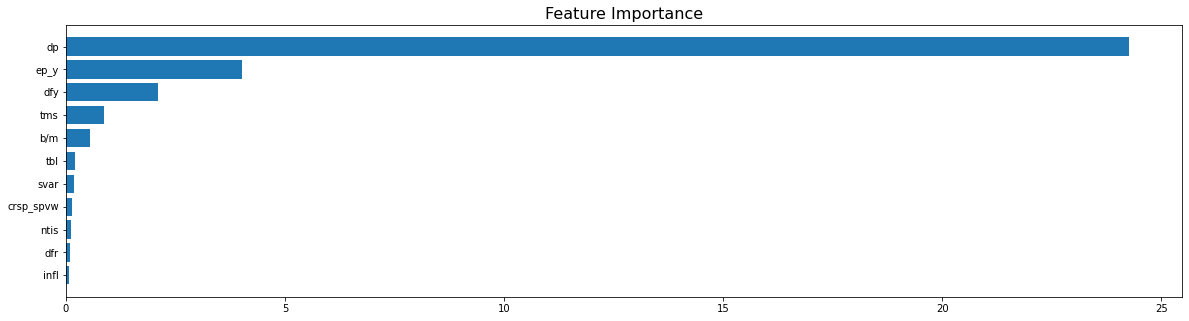

In [75]:
# Display chart
plt.figure(figsize=(20,5))
plt.barh(np.arange(len(importance_df)),importance_df.magnitude.values)
plt.yticks(np.arange(len(importance_df)),importance_df.index.values)
plt.title('Feature Importance',size=16)
plt.show()

c.	Repeat the two steps above, but by using a measure of the sensitivity of predictions to each input variable, as outlined in the lectures.

In [78]:
results = []
print('Computing feature importance...')
for feature in tqdm(df_10.index.values):
    tmp = X_test.loc[:,feature].copy()
    median = X_test.median()
    X_temp = pd.DataFrame(index=X_test.index,columns=X_test.columns)
    X_temp.fillna(median,inplace=True)
    X_temp.loc[:,feature] = tmp
    y_preds = best_model.predict(X_temp.values,batch_size=256).reshape(-1,1) 
    results.append({'feature':tmp.values.reshape(1,-1)[0],'pred_return':y_preds.reshape(1,-1)[0]})  

Computing feature importance...


  0%|                                                    | 0/10 [00:00<?, ?it/s]

4312/4312 [==============================] - 3s 633us/step


 10%|████▍                                       | 1/10 [01:05<09:47, 65.26s/it]

4312/4312 [==============================] - 3s 618us/step


 20%|████████▊                                   | 2/10 [02:09<08:38, 64.87s/it]

4312/4312 [==============================] - 3s 620us/step


 30%|█████████████▏                              | 3/10 [03:14<07:34, 64.93s/it]

4312/4312 [==============================] - 3s 617us/step


 40%|█████████████████▌                          | 4/10 [04:19<06:28, 64.74s/it]

4312/4312 [==============================] - 3s 753us/step


 50%|██████████████████████                      | 5/10 [05:44<06:00, 72.07s/it]

4312/4312 [==============================] - 3s 622us/step


 60%|██████████████████████████▍                 | 6/10 [06:54<04:45, 71.29s/it]

4312/4312 [==============================] - 3s 624us/step


 70%|██████████████████████████████▊             | 7/10 [08:05<03:33, 71.29s/it]

4312/4312 [==============================] - 4s 937us/step


 80%|███████████████████████████████████▏        | 8/10 [09:23<02:26, 73.38s/it]

4312/4312 [==============================] - 3s 727us/step


 90%|███████████████████████████████████████▌    | 9/10 [10:39<01:14, 74.24s/it]

4312/4312 [==============================] - 3s 630us/step


100%|███████████████████████████████████████████| 10/10 [11:48<00:00, 70.83s/it]


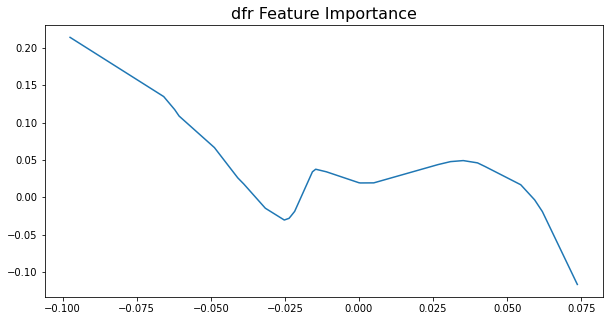

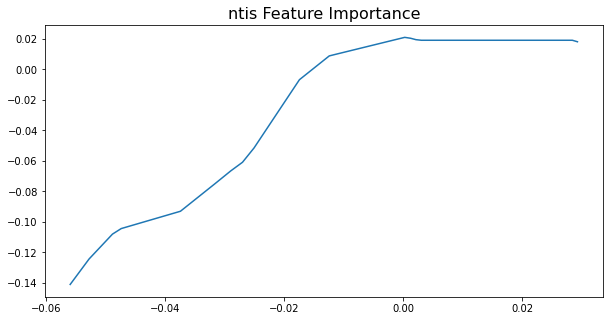

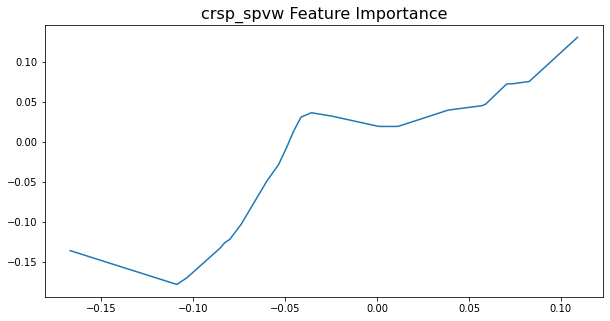

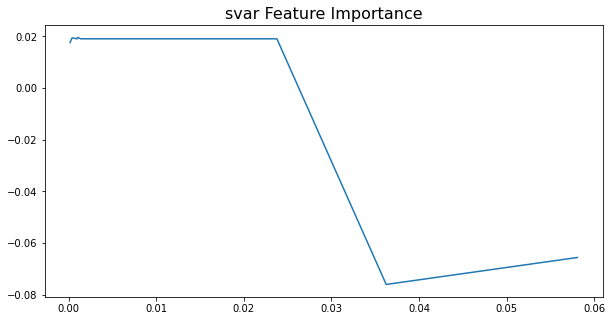

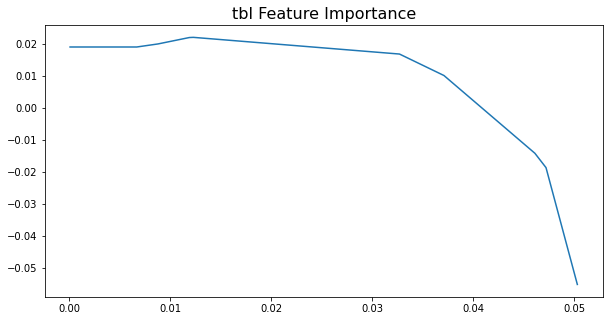

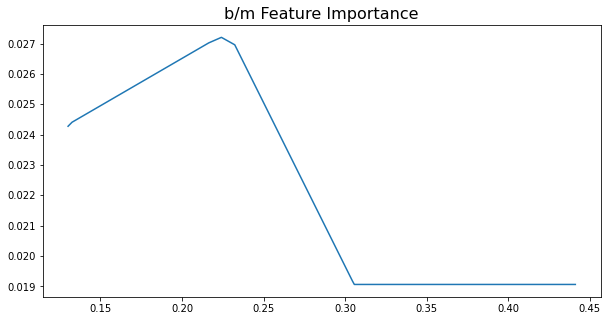

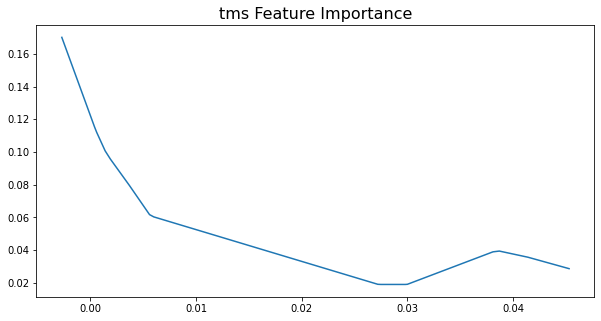

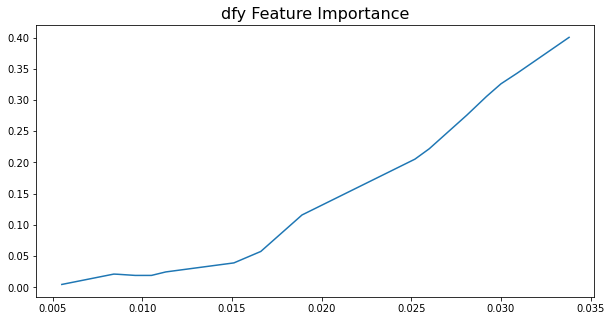

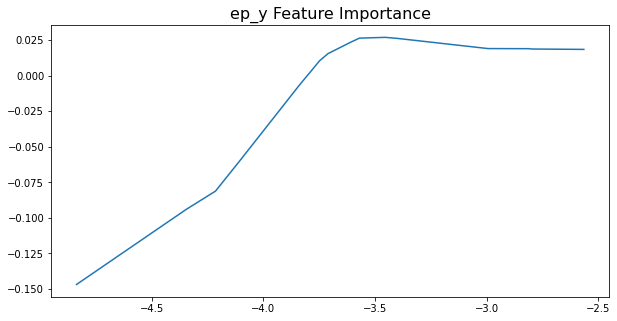

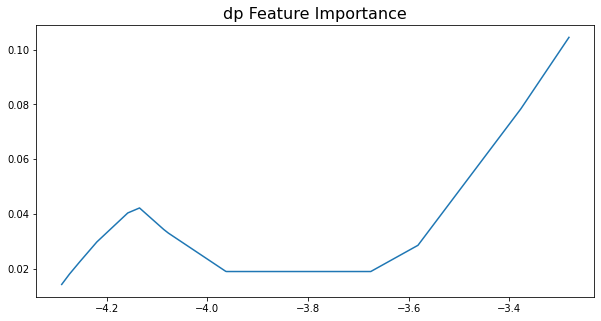

In [107]:
features = df_10.index.values
for i in range(len(results)):
    result = results[i]
    tmp_df = pd.DataFrame(result,index = np.arange(len(result['feature'])))
    tmp_df.sort_values(by=['feature'],inplace=True)
    plt.figure(figsize=(10,5))
    plt.title(f'{features[i]} Feature Importance',size=16)
    plt.plot(tmp_df.feature,tmp_df.pred_return)
    plt.show()

4.Fit a penalised linear model (LASSO) to the same data, using validation data to pick the best penalty (e.g., you can use the “sklearn” package in Python to do this easily). Compare its test data performance to the neural network. 

In [8]:
import seaborn as sns
from sklearn.metrics import r2_score, get_scorer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split

In [9]:
#because lasso need too much memory, we have to reduce the size of train data
X_cv_reduced, x_tmp, y_cv_reduced, y_tmp = train_test_split(X,y,test_size=0.7,shuffle=True)

In [10]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
lasso = Lasso()
grid = {'alpha': np.linspace(0.1,2,4)}

gscv = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error',cv=cv, verbose=10)
results = gscv.fit(X_cv_reduced.values, y_cv_reduced.values)
print('MSE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 15 folds for each of 4 candidates, totalling 60 fits
[CV 1/15; 1/4] START alpha=0.1..................................................
[CV 1/15; 1/4] END ..................alpha=0.1;, score=-0.031 total time=   4.5s
[CV 2/15; 1/4] START alpha=0.1..................................................
[CV 2/15; 1/4] END ..................alpha=0.1;, score=-0.031 total time=   3.8s
[CV 3/15; 1/4] START alpha=0.1..................................................
[CV 3/15; 1/4] END ..................alpha=0.1;, score=-0.029 total time=   3.4s
[CV 4/15; 1/4] START alpha=0.1..................................................
[CV 4/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.2s
[CV 5/15; 1/4] START alpha=0.1..................................................
[CV 5/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.2s
[CV 6/15; 1/4] START alpha=0.1..................................................
[CV 6/15; 1/4] END ..................alpha=0.1;,

[CV 6/15; 4/4] END ..................alpha=2.0;, score=-0.031 total time=   3.4s
[CV 7/15; 4/4] START alpha=2.0..................................................
[CV 7/15; 4/4] END ..................alpha=2.0;, score=-0.031 total time=   3.4s
[CV 8/15; 4/4] START alpha=2.0..................................................
[CV 8/15; 4/4] END ..................alpha=2.0;, score=-0.030 total time=   3.3s
[CV 9/15; 4/4] START alpha=2.0..................................................
[CV 9/15; 4/4] END ..................alpha=2.0;, score=-0.028 total time=   3.4s
[CV 10/15; 4/4] START alpha=2.0.................................................
[CV 10/15; 4/4] END .................alpha=2.0;, score=-0.031 total time=   3.4s
[CV 11/15; 4/4] START alpha=2.0.................................................
[CV 11/15; 4/4] END .................alpha=2.0;, score=-0.029 total time=   3.4s
[CV 12/15; 4/4] START alpha=2.0.................................................
[CV 12/15; 4/4] END ........

In [35]:
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test.values).reshape(-1,1)
y_pred_top = best_model.predict(top_X_test).reshape(-1,1)
y_pred_low = best_model.predict(bottom_X_test).reshape(-1,1)
R2_oos_LASSO = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['LASSO'])
R2_oos_LASSO.iloc[0,0] = r_squared(y_pred,y_test.values)
R2_oos_LASSO.iloc[0,1] = r_squared(y_pred_top,top_y_test)
R2_oos_LASSO.iloc[0,2] = r_squared(y_pred_bottom,bottom_y_test)

In [36]:
R2_oos_LASSO*100

,R2_OOS,R2_OOS_top1000,R2_OOS_low1000
LASSO,0.262816,0.240347,26.439365


5.Suppose somebody tells you to collect 10 more micro or macro variables that can predict returns and are not in our current dataset. How would you choose those variables, based on the intuitions you have gained in this project?